In [1]:
from qiskit import *
from qiskit.providers.fake_provider import FakeManila, FakeKolkata, FakeSherbrooke
from qiskit_ibm_provider import IBMProvider

import mthree
import matplotlib.pyplot as plt 
from mthree.utils import *
from mthree._helpers import system_info
from qiskit import QuantumCircuit

from mthree.twirling.tw_calibrations import Tw_Calibration
from mthree.twirling.tw_circuits import Tw_Circuit
from mthree.twirling.tw_utils import vals_from_dict

In [2]:
provider = IBMProvider()
backend = FakeKolkata()
num_backend_qubits = system_info(backend)["num_qubits"]
print(num_backend_qubits)

27


In [3]:
def donothing(N):
    qc = QuantumCircuit(N, N)
    for i in range(N):
        qc.measure(i,i)
    return qc

def GHZ(N):
    qc = QuantumCircuit(N, N)
    qc.h(0)
    for i in range(1,N):
        qc.cx(0,i)
    for i in range(N):
        qc.measure(i,i)
    return qc

def m3circuit(N):
    qc = QuantumCircuit(N, N)
    qc.x(range(N))
    qc.h(range(N))
    for kk in range(N // 2, 0, -1):
        qc.ch(kk, kk - 1)
    for kk in range(N // 2, N - 1):
        qc.ch(kk, kk + 1)
    for i in range(N):
        qc.measure(i,i)
    return qc

In [4]:
# from qiskit import Aer
# from qiskit.visualization import plot_histogram
# from qiskit_aer import AerSimulator
# import qiskit_aer.noise as noise

# bit_flip_prob = 0.02  # bit flip readout

# # Build noise model from backend properties
# backend = FakeKolkata()
# noise_model = NoiseModel.from_backend(backend)
# num_backend_qubits = system_info(backend)["num_qubits"]

# # Error probability
# readout_probabilities = [[1-bit_flip_prob, bit_flip_prob], [bit_flip_prob, 1-bit_flip_prob]]   # measurement error 

# # Readout quantum errors
# readout_error = noise.ReadoutError(readout_probabilities)

# # Add errors to noise model
# noise_model = noise.NoiseModel()
# noise_model.add_all_qubit_readout_error(readout_error)

# # Get basis gates from noise model
# basis_gates = noise_model.basis_gates

In [5]:
# N=24
# #qc = donothing(N)
# qc = GHZ(N)
# #qc = m3circuit(N)

# # Perform a noise simulation
# backend = AerSimulator(noise_model=noise_model, basis_gates=basis_gates)
# transpiled_circuit = transpile(qc, backend)
# result = backend.run(transpiled_circuit, shots=2**16).result()
# counts = result.get_counts()
# print(expval(items=counts, exp_ops=N*'Z'))

# measurement_map = final_measurement_mapping(qc)

# tw_circuit = Tw_Circuit(backend, circuit=qc)
# tw_circuit.tw_data_from_backend(shots=2**13)
# tw_counts = tw_circuit.to_untwirled_data()

# tw_calib = Tw_Calibration(backend, qubits=range(num_backend_qubits))
# tw_calib.tw_data_from_backend(shots=2**13)
# tw_calib.tw_expval(counts=tw_counts, operator=N*'Z', mapping=measurement_map)

In [6]:
def unmitig_mitig_expval(N, trials):
    unmitig_expvals = []
    mitig_expvals = []

    op = N*'Z'
    qc = GHZ(N)
    transpiled_circuit = transpile(qc, backend)
    measurement_map = final_measurement_mapping(transpiled_circuit)
    qubits_to_calibrate = vals_from_dict(measurement_map)

    for i in range(trials):
        result = backend.run(transpiled_circuit, shots=2**13).result()
        counts = result.get_counts()
        unmitig_val = expval(items=counts, exp_ops=op)
        unmitig_expvals.append(unmitig_val)

        tw_circuit = Tw_Circuit(backend, circuit=transpiled_circuit)
        tw_circuit.tw_data_from_backend(shots=2**13)
        tw_counts = tw_circuit.to_untwirled_data()

        tw_calib = Tw_Calibration(backend, qubits=qubits_to_calibrate)
        tw_calib.tw_data_from_backend(shots=2**13)
        mitig_val = tw_calib.tw_expval(counts=tw_counts, operator=op, mapping=measurement_map)
        mitig_expvals.append(mitig_val)
    
    return [np.average(unmitig_expvals), np.std(unmitig_expvals), np.average(mitig_expvals), np.std(mitig_expvals)]

In [7]:
unmitig_mitig_expval(N=4, trials=10)

[0.9200927734375,
 0.0038633662909702943,
 0.974748388649776,
 0.00798836945119689]

In [8]:
N_range = [2,4,6,8,10,12]
#N_range = [2,4]
unmitig_vals = []
unmitig_stds = []
mitig_vals = []
mitig_stds = []

for qubits in N_range:
    result = unmitig_mitig_expval(N=qubits, trials=10)
    unmitig_vals.append(result[0])
    unmitig_stds.append(result[1])
    mitig_vals.append(result[2])
    mitig_stds.append(result[3])

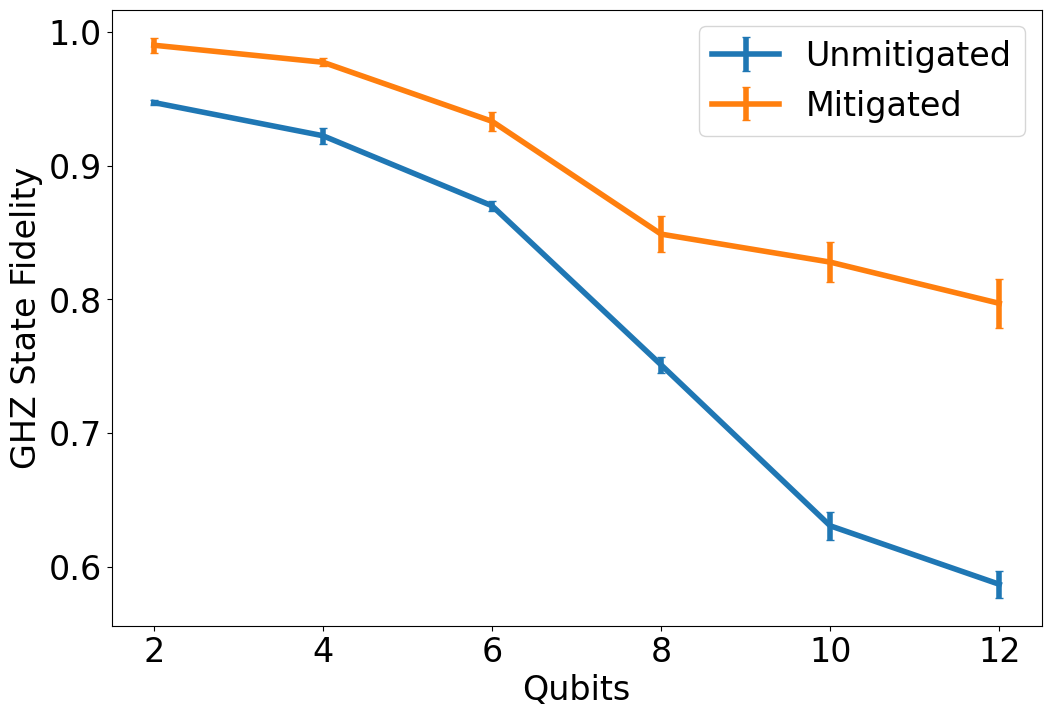

In [23]:
plt.figure(figsize=(12,8))
plt.rcParams['font.size'] = 24
plt.errorbar(N_range, unmitig_vals, yerr=unmitig_stds, capsize=3, label='Unmitigated', linewidth=4)
plt.errorbar(N_range, mitig_vals, yerr=mitig_stds, capsize=3, label='Mitigated', linewidth=4)
plt.xlabel('Qubits')
plt.ylabel('GHZ State Fidelity')
plt.legend()
plt.savefig("fidelity.jpg",bbox_inches ="tight", transparent = True)
plt.show()